# Description

**Author:** Wouter Berghuijs & Anna Luisa Hemshorn de Sánchez

**Affiliation:** (1) Department of Earth Sciences, VU Amsterdam, (2) Institute of Environmental Studies (IVM), VU Amsterdam, (3) Deltares

**Contact:** a.l.hemshorndesanchez@vu.nl

**Version:** V1

**Date:** Oct 20, 2025

**Description:** Data used in this notebook is obtained from: do Nascimento, T.V.M., Rudlang, J., Höge, M. et al. EStreams: An integrated dataset and catalogue of streamflow, hydro-climatic and landscape variables for Europe. _Sci Data_ 11, 879 (2024). https://doi.org/10.1038/s41597-024-03706-1

In this code we compare the seasonality of mean, maximum and minimum flow to the seasonal dominance calculated a previous script.

# Import packages

In [1]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
from shapely import wkt
import colorcet as cc
import colorstamps
from datetime import datetime, timedelta
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import numpy as np
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
from scipy.stats import linregress
from scipy.stats import theilslopes
import os
import cartopy.crs as ccrs
from cmcrameri import cm
from matplotlib.colors import LinearSegmentedColormap

# Import files

In [2]:
# Get main directories
nb_dir = Path.cwd()
parent_dir = nb_dir.parent.parent.parent.parent
fp = parent_dir / "Data/Europe/estreams/EStreams_v1.3/"

# Output directories
fp_gh = parent_dir / "Code/GitHub/streamflow_sensitivity_europe/"
fp_processed = fp_gh / "data/processed/" 
#fp_tempstats = fp_processed / "02_temporal_stats/" 
fp_stats = fp_processed / "04_directional_stats/" 
#fp_out_hyr = fp_tempstats / "02_hyearly/"
fp_figures = fp_gh / "figures/" 
fp_output = fp /f"ouput"


seasonal_dominance_df = pd.read_csv(fp_stats/"result_gdf_seasonal_dominance.csv")
directional_stats_df = pd.read_csv(fp_stats/"merged_df_DirectionalStats.csv")[['basin_id', 'Mean_Day', 'Date_R']]
Qmax_df = pd.read_csv(fp_stats/"results_Qmax.csv").drop(columns=['result_x', 'result_y'])
Qmin_df = pd.read_csv(fp_stats/"results_Qmin.csv").drop(columns=['result_x', 'result_y'])

/var/folders/gx/zty05h6s2_555flc2721fjrc0000gn/T/ipykernel_5016/2920959904.py:17: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  directional_stats_df = pd.read_csv(fp_stats/"merged_df_DirectionalStats.csv")[['basin_id', 'Mean_Day', 'Date_R']]


# Pre-process

In [3]:
directional_stats_df.rename(columns={'Mean_Day': 'Qmean_com_day', 'Date_R': 'Qmean_date_R'}, inplace=True)
Qmax_df.rename(columns={'station_name': 'basin_id', 'R_Qmax': 'Qmax_R', 'Angle_Qmax': 'Qmax_com_angle', 'result_x_Qmax': 'Qmax_result_x', 'result_y_Qmax': 'Qmax_result_y'}, inplace=True)
Qmin_df.rename(columns={'station_name': 'basin_id', 'R_Qmin': 'Qmin_R', 'Angle_Qmin': 'Qmin_com_angle', 'result_x_Qmin': 'Qmin_result_x', 'result_y_Qmin': 'Qmin_result_y'}, inplace=True)

In [4]:
merged_df = pd.merge(seasonal_dominance_df,
                     directional_stats_df,
                     left_on='basin_id',
                     right_on='basin_id',
                     how='inner')  # 'left', 'right', or 'outer'

merged_df = pd.merge(merged_df,
                     Qmax_df,
                     left_on='basin_id',
                     right_on='basin_id',
                     how='inner')

merged_df = pd.merge(merged_df,
                     Qmin_df,
                     left_on='basin_id',
                     right_on='basin_id',
                     how='inner')

In [5]:
merged_df['Qmax_wrapped_angle'] = merged_df['Qmax_com_angle'] % (2 * np.pi)
merged_df['Qmin_wrapped_angle'] = merged_df['Qmin_com_angle'] % (2 * np.pi)

merged_df['Qmax_com_day'] = merged_df['Qmax_wrapped_angle'] / (2 * np.pi) * 365
merged_df['Qmin_com_day'] = merged_df['Qmin_wrapped_angle'] / (2 * np.pi) * 365

# Create a new DataFrame for the smoothed values
merged_df['Qmean_com_day'] = merged_df['Qmean_com_day'].round()
merged_df['Qmax_com_day'] = merged_df['Qmax_com_day'].round()
merged_df['Qmin_com_day'] = merged_df['Qmin_com_day'].round()

#merged_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry', crs="EPSG:4326")
merged_df["geometry"] = merged_df["wkt_geometry"].apply(wkt.loads)
merged_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry', crs="EPSG:4326")

# Load the Europe boundaries (Natural Earth dataset)
europe = gpd.read_file(parent_dir/"Data/Admin/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp") #CNTR_BN_01M_2020_3035.shp/CNTR_BN_01M_2020_3035.shp')#
europe = europe[(europe['CONTINENT'].str.contains('Europe', case=False, na=False)) |
                ((europe.geometry.bounds['minx'] >= -10) &     
                 (europe.geometry.bounds['maxx'] <= 50) &
                 (europe.geometry.bounds['miny'] >= 30) & 
                 (europe.geometry.bounds['maxy'] <= 70))] #europe = europe.cx[-10:50, 30:70] #europe = europe[europe['CONTINENT'] == 'Europe']

In [6]:
# Initialize an empty list to store smoothed values
smoothed = pd.DataFrame({'day': range(1,366)})

# Loop through each day from 1 to 365
for col_com_day, col_dom, col_smoothed_dom in zip(['Qmean_com_day', #Option 1: use total streamflow seasonality (as in Berghuijs et al., 2025)
                                                   'Qmax_com_day', # Option 2: use Qmax 
                                                   'Qmin_com_day'],# Option 3: use Qmin
                                                  ['QmeanPmean_dominance', 'QmaxPmean_dominance','QminPmean_dominance'],
                                                  ['Qmean_smoothed_dominance', 'Qmax_smoothed_dominance','Qmin_smoothed_dominance']
                                        ):
    for day in range(1, 366):
        
        # Get the days in the window [day-20, day+20]
        window_days = list(range(day - 20, day + 21))

        # Ensure days wrap around if needed (e.g., day - 5 < 1 or day + 5 > 365)
        window_days = [d if 1 <= d <= 365 else (d + 365 if d < 1 else d - 365) for d in window_days]

        window_values_Q = merged_df[merged_df[col_com_day].isin(window_days)][col_dom]

        # Compute mean ignoring NaNs for each column
        mean_val_Q = window_values_Q.mean(skipna=True)
        
        if window_values_Q.count() < 20:
            mean_val_Q = float('nan')
        else:
            mean_val_Q = window_values_Q.mean(skipna=True)

        # Save results
        smoothed.loc[smoothed['day'] == day, col_smoothed_dom] = mean_val_Q

# Convert to DataFrame
smoothed_df = pd.DataFrame(smoothed)

# Visualize

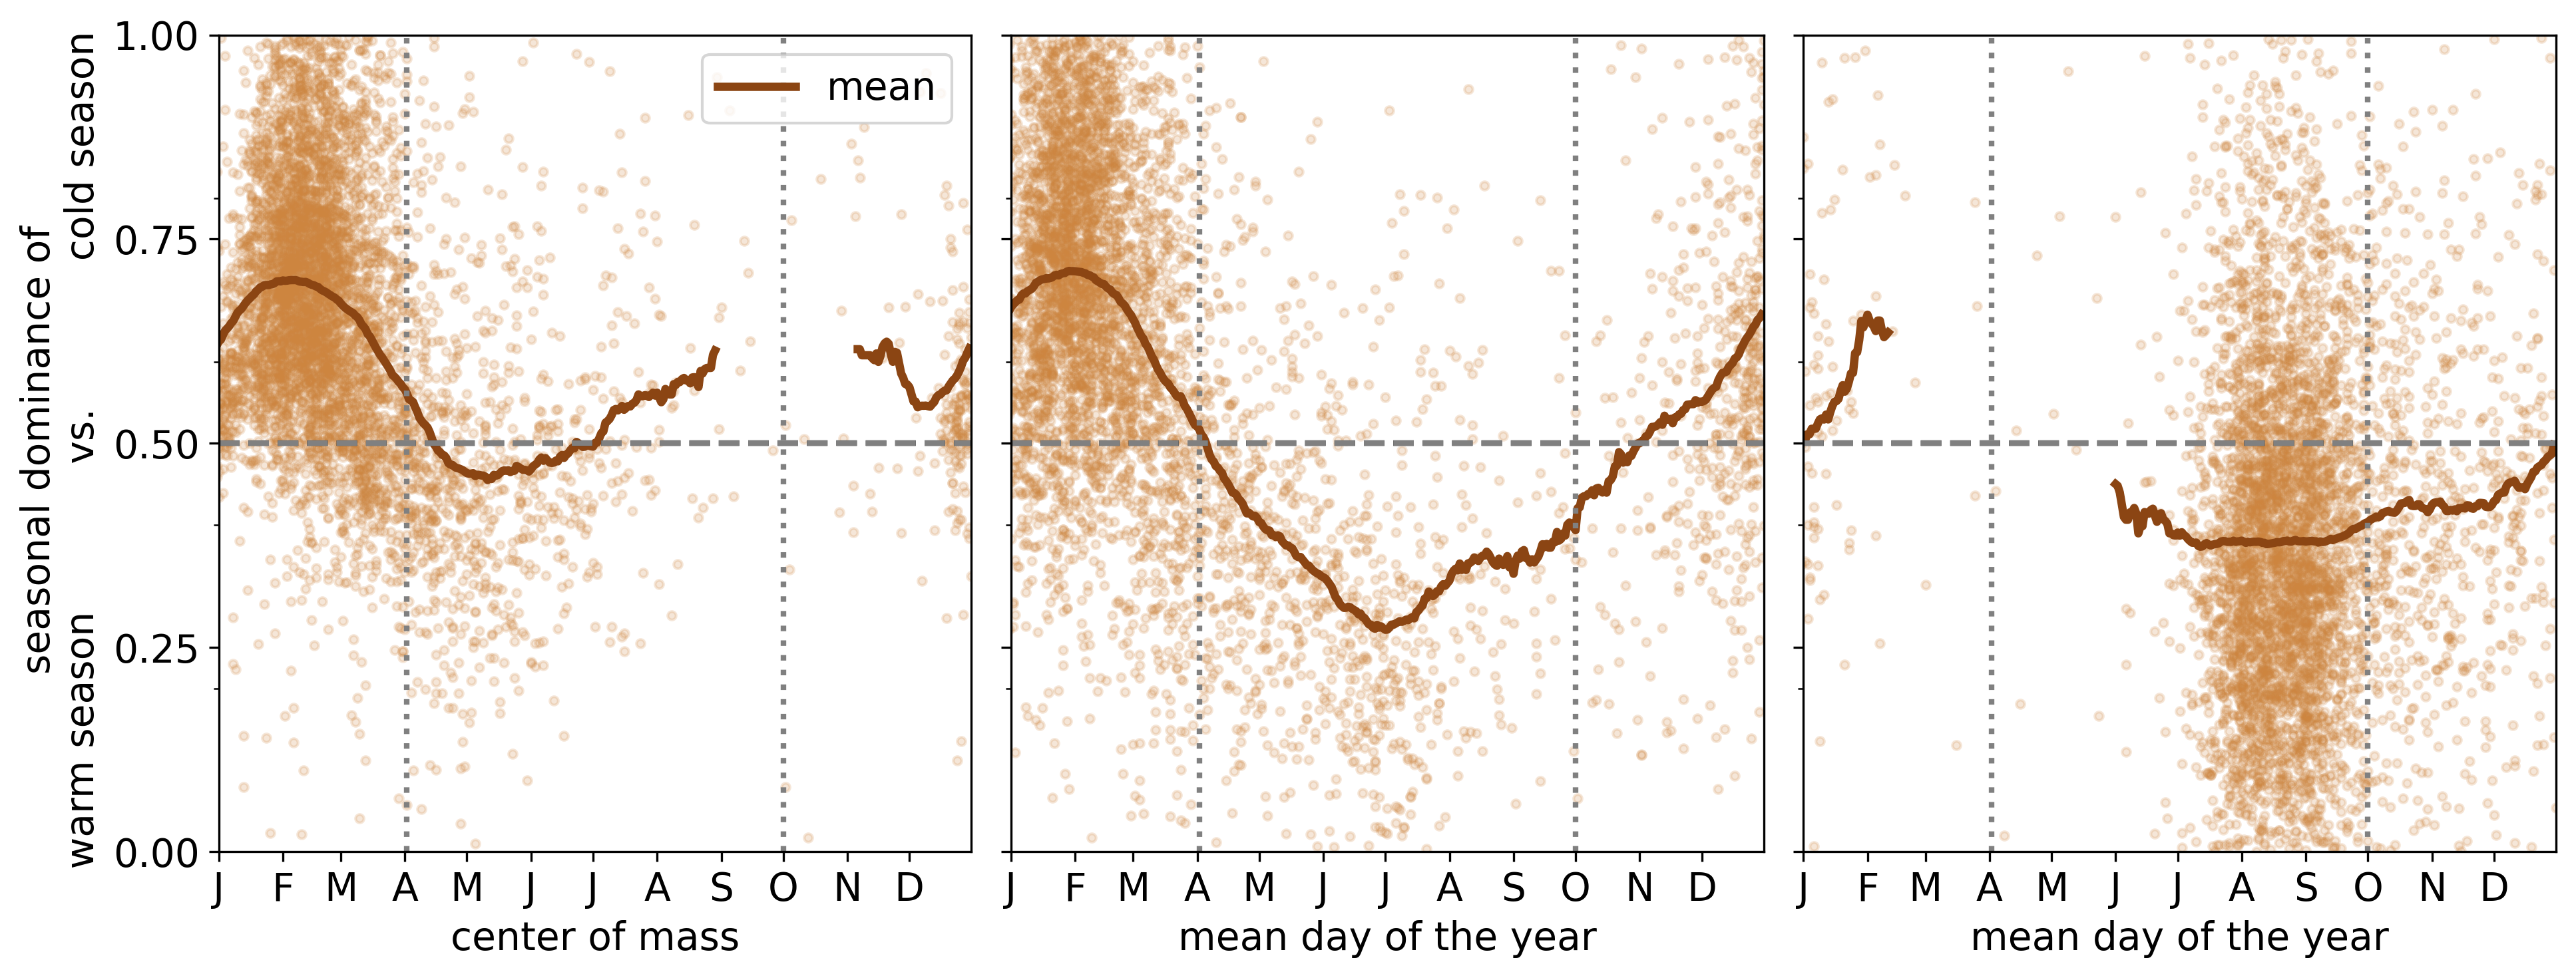

In [7]:
ft = 14
# Set up the figure and axes
fig, axes = plt.subplots(1,3, figsize=(13, 5), sharey=True, dpi=300) 
fig.patch.set_alpha(0)

# Define the start of each month in terms of the day of the year
monthly_ticks = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
monthly_labels = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']

axes[0].set_ylabel('seasonal dominance of \n warm season            vs.            cold season  ', fontsize=ft)

for ax, smoothed_dom, com_day, dom in zip(axes, 
                                          ['Qmean_smoothed_dominance','Qmax_smoothed_dominance', 'Qmin_smoothed_dominance'],
                                          ['Qmean_com_day', 'Qmax_com_day', 'Qmin_com_day'],
                                          ['QmeanPmean_dominance','QmaxPmean_dominance', 'QminPmean_dominance']
                                        ):
    ax.plot(merged_df[com_day], merged_df[dom],'.', color='peru', alpha=0.2)
    smoothed_df[smoothed_dom].plot(ax=ax, color='saddlebrown',linewidth=3, label='mean')
    ax.axhline(y=0.5, color='black', linestyle='--', linewidth=2)
    
    ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=2)
    ax.axvline(x=92, color='gray', linestyle=':', linewidth=2)
    ax.axvline(x=274, color='gray', linestyle=':', linewidth=2)
    # Set the limits and labels
    ax.set_ylim(0, 1)
    ax.set_xlim(1, 365)

    # Set x-axis ticks to represent the start of each month
    ax.set_xticks(monthly_ticks, monthly_labels)
    ax.set_yticks([0,0.25,0.5,0.75,1.0])
    ax.tick_params(labelsize=ft)

axes[0].legend(loc='upper right', fontsize=ft)
axes[0].set_xlabel('center of mass', fontsize=ft)
axes[1].set_xlabel('mean day of the year', fontsize=ft)
axes[2].set_xlabel('mean day of the year', fontsize=ft)
    
plt.tight_layout()
plt.savefig(fp_figures/"03_sensitivities/02_seasonal/seasonality/A-OCT_center-of-mass_vs_seasonal-dominance_with-scatter.png", dpi=300, bbox_inches='tight')
plt.savefig(fp_figures/"03_sensitivities/02_seasonal/seasonality/A-OCT_center-of-mass_vs_seasonal-dominance_with-scatter.pdf", bbox_inches='tight')

plt.show()